<a href="https://colab.research.google.com/github/rodmart21/Sports_analytics/blob/main/golesEsperados_Logistic_Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install statsbombpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00


In [2]:
pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.7 MB/s eta 0:00:00


## Algo de contexto sobre los goles esperados.

https://github.com/statsbomb/open-data
https://github.com/wswager/womens_soccer_expected_goals_model/blob/main/data_preprocessing/expected_goals_data_preprocessing_notebook.ipynb
https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/tree/master
https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html
https://www.youtube.com/watch?v=310_eW0hUqQ&ab_channel=FriendsofTracking
https://twitter.com/LanusStats/status/1456381238252605443
https://theanalyst.com/eu/2021/06/que-son-los-goles-esperados-xg/


In [3]:
from statsbombpy import sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [4]:
sb.competitions().head()   # En statsbomb tenemos una base de datos con una barbaridad de partidos

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
1,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-02-14T05:41:27.566989,None,None,2024-02-14T05:41:27.566989
2,16,4,Europe,Champions League,male,False,False,2018/2019,2023-03-07T12:20:48.118250,2021-06-13T16:17:31.694,None,2023-03-07T12:20:48.118250
3,16,1,Europe,Champions League,male,False,False,2017/2018,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2021-01-23T21:55:30.425330
4,16,2,Europe,Champions League,male,False,False,2016/2017,2021-08-27T11:26:39.802832,2021-06-13T16:17:31.694,None,2020-07-29T05:00


In [5]:
sb.competitions().shape

(71, 12)

## Hace una carga de las estadísticas desde statsbomb, y después simplemente lo carga en un csv y lo ve desde ahí.

In [7]:
tiros_statsbomb = pd.read_csv('/content/tirosStatsBomb_modeloxG_v2.csv')

In [8]:
tiros_statsbomb.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'bad_behaviour_card',
       'ball_receipt_outcome', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part',
       ...
       'goalkeeper_lost_in_play', 'pass_backheel', 'x', 'y',
       'player_off_permanent', 'goalkeeper_lost_out', 'goalkeeper_success_out',
       'half_end_early_video_end', 'goalkeeper_penalty_saved_to_post',
       'goalkeeper_saved_to_post'],
      dtype='object', length=119)

In [9]:
tiros_statsbomb.shape  # Hay muchísimas columnas, debemos ver cuántas de ellas nos interesan realmente.

(23867, 119)

In [10]:
tiros_statsbomb.columns.str.contains('shot')

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False])

### Nos quedamos con las columnas que contienen la palabra shot

In [11]:
booleanos = pd.Series(tiros_statsbomb.columns).str.contains('shot')
df_test = pd.concat([pd.Series(tiros_statsbomb.columns), booleanos], axis=1)
df_test[df_test.iloc[:,1] == True]

,0,1
41,pass_assisted_shot_id,True
54,pass_shot_assist,True
67,shot_aerial_won,True
68,shot_body_part,True
69,shot_deflected,True
70,shot_end_location,True
71,shot_first_time,True
72,shot_freeze_frame,True
73,shot_key_pass_id,True
74,shot_one_on_one,True


### Varios tipos de variables: categóricas, boolenaas (binarias), propias (las construimos nosotros). Por ejemplo la API no nos da la distancia a la porteria ni el ángulo con el que tiramos. Calculamos la distancia al centro de la portería (fórmula de la distancia), y el ángulo (el que se forma con los 2 palos).

In [12]:
tiros_filt = tiros_statsbomb[['shot_aerial_won',
'shot_body_part',
'shot_first_time',
'shot_deflected',
'shot_one_on_one',
'shot_open_goal',
'shot_outcome',
'shot_technique',
'shot_type',
'play_pattern',
'x',
'y'
]].reset_index(drop=True)
tiros_filt['goal'] = np.where(tiros_filt.shot_outcome == 'Goal', 1,0)
tiros_filt['Distance'] = np.sqrt(np.square(120-tiros_filt['x']) + np.square(40 - tiros_filt['y']))   # (120,40) it is what we take as the centre of the goal.
tiros_filt['angulo'] = np.arctan(7.32 *tiros_filt['x'] /(tiros_filt['x']**2 + tiros_filt['y']**2 - (7.32/2)**2))
tiros_filt.shot_aerial_won = tiros_filt.shot_aerial_won.fillna(False)
tiros_filt.shot_first_time = tiros_filt.shot_first_time.fillna(False)    # Rellenamos las columnas que están vacías con un False.
tiros_filt.shot_one_on_one = tiros_filt.shot_one_on_one.fillna(False)
tiros_filt.shot_open_goal = tiros_filt.shot_open_goal.fillna(False)
tiros_filt.shot_deflected = tiros_filt.shot_open_goal.fillna(False)
tiros_filt.head()

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_outcome,shot_technique,shot_type,play_pattern,x,y,goal,Distance,angulo
0,False,Left Foot,True,False,False,False,Blocked,Half Volley,Open Play,From Kick Off,96.0,38.8,0,24.029981,0.065531
1,False,Left Foot,True,False,False,False,Saved,Half Volley,Open Play,From Kick Off,113.1,40.7,0,6.935416,0.057292
2,False,Right Foot,True,False,False,False,Saved,Half Volley,Open Play,From Kick Off,103.8,41.9,0,16.311039,0.060630
3,False,Head,False,False,False,False,Off T,Normal,Open Play,From Corner,112.2,36.8,0,8.430896,0.058893
4,False,Left Foot,False,False,False,False,Post,Normal,Open Play,Regular Play,97.8,51.5,0,25.001800,0.058595


# I do not understand the formula to get the SHOT ANGLE. I should investigate about it. Lanus did not lose time explaining it.

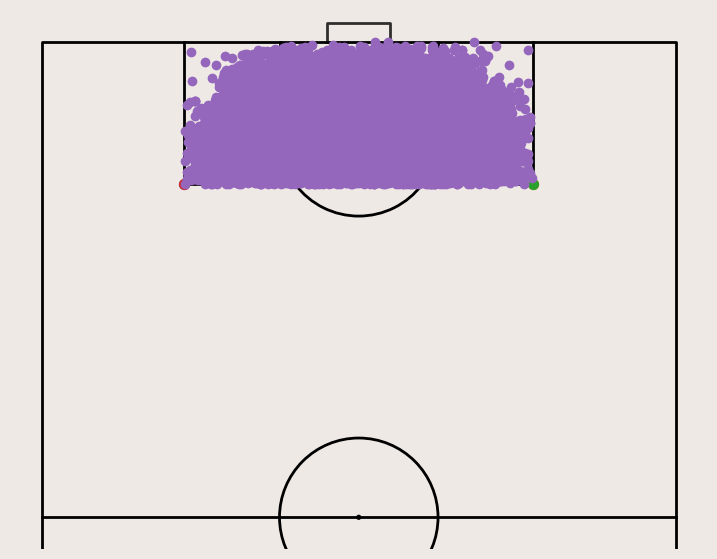

In [13]:
# Representación de los tiros dentro del área.
fig,ax = plt.subplots(figsize=(10,7))
facecolor='#EFE9E6'
fig.set_facecolor(facecolor)
pitch=VerticalPitch(pitch_type='statsbomb',goal_type='box',goal_alpha=.8, pitch_color=facecolor, line_color= 'black', half=True)
pitch.draw(ax=ax)

pitch.scatter(102,18,ax=ax,s=50)
pitch.scatter(102,62,ax=ax,s=50)
pitch.scatter(102,62,ax=ax,s=50)
pitch.scatter(102,18,ax=ax,s=50)

tiros_filt['area']= np.where((tiros_filt['x']>102) & (tiros_filt['y']> 18) & (tiros_filt['y']< 62), True, False)
# Definimos los límiter del área y vemos los tiros que se han producido ahí dentro

pitch.scatter(tiros_filt[tiros_filt['area']== True].x, tiros_filt[tiros_filt['area']== True].y, ax=ax)

### El coeficiente de correlación más común calculado por corr() es el coeficiente de correlación de Pearson. Este coeficiente mide la fuerza y la dirección de la relación lineal entre dos variables. Valores cercanos a 1: Indican que a medida que una variable aumenta, la otra tiende a aumentar también (correlación positiva fuerte).
### Valores cercanos a -1: Indican que a medida que una variable aumenta, la otra tiende a disminuir (correlación negativa fuerte).
### Valores cercanos a 0: Indican que no hay una relación lineal fuerte entre las variables.

In [23]:
tiros_filt[['shot_aerial_won','shot_first_time','shot_one_on_one']].corr()

,shot_aerial_won,shot_first_time,shot_one_on_one
shot_aerial_won,1.000000,-0.205840,-0.004781
shot_first_time,-0.205840,1.000000,-0.157745
shot_one_on_one,-0.004781,-0.157745,1.000000


### Usamos modelos de aprendizaje supervisado. Variable continua=Regresión, Variable discreta=Clasificación.

### Prueba con Logistic Regresion, es un modelo simple pero que funciona bien en este caso de uso.

### Dentro de los transformers, se usa uno categórico ('cat').
### -OneHotEncoder transforma las categorías que vienen descritas en variables dummy (0/1) con sus posibles combinaciones. Ej: El OneHotEncoder convierte cada valor categórico en una columna binaria (dummy variable). Por ejemplo, si la columna 'shot_body_part' tiene los valores 'foot', 'head', y 'other', el OneHotEncoder convertirá esta columna en tres columnas binarias:'shot_body_part_foot','shot_body_part_head','shot_body_part_other'.

### Toma la decisión de hacerlo de esta forma, no es la única correcta.

In [27]:
tiros_filt.head(3)

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_outcome,shot_technique,shot_type,play_pattern,x,y,goal,Distance,angulo,area
0,False,Left Foot,True,False,False,False,Blocked,Half Volley,Open Play,From Kick Off,96.0,38.8,0,24.029981,0.065531,False
1,False,Left Foot,True,False,False,False,Saved,Half Volley,Open Play,From Kick Off,113.1,40.7,0,6.935416,0.057292,True
2,False,Right Foot,True,False,False,False,Saved,Half Volley,Open Play,From Kick Off,103.8,41.9,0,16.311039,0.060630,True


In [14]:
y = tiros_filt['goal']
X = tiros_filt.drop(columns=['goal', 'shot_outcome'])  # Eliminamos columnas que son resultado.

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 13)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['shot_body_part', 'shot_technique', 'shot_type', 'play_pattern'])
    ],
    remainder= 'passthrough'
)

# Incluimos dos pasos, el preprocesado y el clasificador.
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

model.fit(X_test, y_test)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['shot_body_part',
                                                   'shot_technique',
                                                   'shot_type',
                                                   'play_pattern'])])),
                ('classifier', LogisticRegression())])

In [15]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
df_cm

,0,1
0,4212,44
1,431,87


### With this confusion matrix, we can separate and get each value that we want.

In [16]:
from sklearn.metrics import confusion_matrix
preds = model.predict(X_test)
df_cm = pd.DataFrame(confusion_matrix(y_test, preds))  # return  tn, fp, fn, tp

VP = df_cm.iloc[1,1]
VN = df_cm.iloc[0,0]
FN = df_cm.iloc[1,0]
FP = df_cm.iloc[0,1]
exactitud = accuracy = (VP + VN)/(VP + VN + FN + FP)
precision = VP/(VP + FP)
sensibilidad = VP/(VP + FN)
especifidad = VN/(FP + VN)

print('La exactitud del modelo elegido es: ' + str(exactitud))
print('La precision del modelo elegido es: ' + str(precision))
print('La sensibilidad del modelo elegido es: ' + str(sensibilidad))
print('La especifidad del modelo elegido es: ' + str(especifidad))

La exactitud del modelo elegido es: 0.9005027230833682
La precision del modelo elegido es: 0.6641221374045801
La sensibilidad del modelo elegido es: 0.16795366795366795
La especifidad del modelo elegido es: 0.9896616541353384


In [17]:
probabilities = model.predict_proba(X)[:,1]   # Percentage to convert the goal.
probabilities = pd.DataFrame(probabilities, columns=['xG'])
X_with_prob = pd.concat([X.reset_index(drop=True), probabilities], axis=1)
X_with_prob

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_technique,shot_type,play_pattern,x,y,Distance,angulo,area,xG
0,False,Left Foot,True,False,False,False,Half Volley,Open Play,From Kick Off,96.0,38.8,24.029981,0.065531,False,0.041904
1,False,Left Foot,True,False,False,False,Half Volley,Open Play,From Kick Off,113.1,40.7,6.935416,0.057292,True,0.369699
2,False,Right Foot,True,False,False,False,Half Volley,Open Play,From Kick Off,103.8,41.9,16.311039,0.060630,True,0.108306
3,False,Head,False,False,False,False,Normal,Open Play,From Corner,112.2,36.8,8.430896,0.058893,True,0.110676
4,False,Left Foot,False,False,False,False,Normal,Open Play,Regular Play,97.8,51.5,25.001800,0.058595,False,0.040538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23862,False,Right Foot,False,False,False,False,Normal,Open Play,Regular Play,109.1,29.8,14.928161,0.062420,True,0.122714
23863,False,Right Foot,False,False,True,False,Normal,Open Play,From Counter,114.6,51.4,12.614278,0.053172,True,0.312923
23864,False,Right Foot,False,False,False,False,Normal,Open Play,From Throw In,98.3,56.9,27.504545,0.055777,False,0.027339
23865,False,Left Foot,False,False,False,False,Normal,Open Play,Regular Play,102.9,58.1,24.900201,0.053940,True,0.032759


In [31]:
tiros_filt.goal.sum(), X_with_prob.xG.sum()     # We compare the total number of goals and the sum of the expected goals.
# In a perfect model both numbers should be the same.

(2592, 2530.1396589968354)

In [32]:
X_with_prob[X_with_prob['shot_type'] == 'Penalty']

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_technique,shot_type,play_pattern,x,y,Distance,angulo,area,xG
128,False,Right Foot,False,False,False,False,Normal,Penalty,Other,108.0,40.0,12.000000,0.059592,True,0.626098
147,False,Left Foot,False,False,False,False,Normal,Penalty,Other,108.0,40.0,12.000000,0.059592,True,0.625969
161,False,Right Foot,False,False,False,False,Normal,Penalty,Other,108.1,40.1,11.900420,0.059514,True,0.630247
162,False,Left Foot,False,False,False,False,Normal,Penalty,Other,108.1,40.1,11.900420,0.059514,True,0.630119
163,False,Left Foot,False,False,False,False,Normal,Penalty,Other,108.1,40.1,11.900420,0.059514,True,0.630119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23242,False,Right Foot,False,False,True,False,Normal,Penalty,Other,107.7,39.9,12.300406,0.059753,True,0.645268
23269,False,Right Foot,False,False,False,False,Normal,Penalty,Other,108.3,39.9,11.700427,0.059502,True,0.637676
23438,False,Right Foot,False,False,False,False,Normal,Penalty,Other,108.0,40.0,12.000000,0.059592,True,0.626098
23648,False,Left Foot,False,False,False,False,Normal,Penalty,Other,108.0,40.0,12.000000,0.059592,True,0.625969


In [38]:
X_with_prob.columns

Index(['shot_aerial_won', 'shot_body_part', 'shot_first_time',
       'shot_deflected', 'shot_one_on_one', 'shot_open_goal', 'shot_technique',
       'shot_type', 'play_pattern', 'x', 'y', 'Distance', 'angulo', 'area',
       'xG'],
      dtype='object')

In [39]:
X_with_prob[X_with_prob['shot_type'] == 'Penalty'].describe()

,x,y,Distance,angulo,xG
count,344.000000,344.000000,344.000000,344.000000,344.000000
mean,108.156686,40.165116,11.849654,0.059468,0.636364
std,0.354417,0.337550,0.340933,0.000261,0.016531
min,107.100000,39.400000,11.045361,0.058822,0.588329
25%,108.000000,40.000000,11.900000,0.059506,0.626098
50%,108.100000,40.100000,11.901681,0.059550,0.630247
75%,108.100000,40.100000,12.000000,0.059592,0.652581
max,109.000000,41.000000,12.909686,0.060153,0.672444


In [35]:
a=X_with_prob[X_with_prob['shot_type'] == 'Penalty']

In [36]:
a.xG.mean()

0.6363636151402963

In [40]:
X_with_prob.head(2)

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_technique,shot_type,play_pattern,x,y,Distance,angulo,area,xG
0,False,Left Foot,True,False,False,False,Half Volley,Open Play,From Kick Off,96.0,38.8,24.029981,0.065531,False,0.041904
1,False,Left Foot,True,False,False,False,Half Volley,Open Play,From Kick Off,113.1,40.7,6.935416,0.057292,True,0.369699


In [42]:
X_with_prob[X_with_prob['shot_open_goal']==True]  # Shots just in front of the goal, really high expected goals also.

,shot_aerial_won,shot_body_part,shot_first_time,shot_deflected,shot_one_on_one,shot_open_goal,shot_technique,shot_type,play_pattern,x,y,Distance,angulo,area,xG
14,False,Right Foot,True,True,False,True,Normal,Open Play,Regular Play,114.4,36.9,6.400781,0.057945,True,0.762884
133,False,Right Foot,True,True,False,True,Volley,Open Play,From Corner,117.2,35.6,5.215362,0.057170,True,0.590234
384,False,Right Foot,True,True,False,True,Half Volley,Open Play,From Goal Kick,117.6,40.3,2.418677,0.055694,True,0.845507
403,False,Right Foot,True,True,False,True,Volley,Open Play,From Corner,118.7,35.4,4.780167,0.056620,True,0.608253
517,False,Right Foot,True,True,False,True,Normal,Open Play,From Goal Kick,115.6,43.8,5.813777,0.055364,True,0.795954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23584,False,Head,False,True,True,True,Normal,Open Play,From Throw In,117.7,36.7,4.022437,0.056670,True,0.728758
23678,False,Left Foot,True,True,False,True,Half Volley,Open Play,Regular Play,115.3,35.1,6.789698,0.058090,True,0.708889
23684,False,Other,False,True,True,True,Normal,Open Play,From Corner,118.7,42.3,2.641969,0.054711,True,0.636577
23733,False,Head,False,True,False,True,Normal,Open Play,From Corner,115.5,38.3,4.810405,0.057088,True,0.518307


### Una validación más que nos sirve para ver como los penaltis tienen una alta probabilidad de conversión a gol.

### Es importante hacer los parse necesarios a los modelos para luego aplicar los modelos a los datos de forma correcta.